`CMPE-255. Fall 2023`

`Student Name : Sirisha Polisetty`


# The Traveling Salesman

Larry, a traveling salesman with Cheapsales, Inc., spends 365 (366 on leap years) days a year on the road, visiting the entire USA.

Bigspender, Inc. acquires Cheapsales. They are committed to bringing more resources into the sales organization. Larry, initially hopeful that his traveling days may be reduced, turns skeptical when his new manager states the conditions to hire more traveling salesmen:

“We shall hire the minimal number of salesman needed to cover all locations without the need for expensive air traveling”.



## The Data

| Item | Value | Notes |
| ---- | ---- | ---- |
| Locations to visit every year |	4,000	| The total number of locations the sales team needs to visit every year |
| Maximum region to region travel |	150 miles |	The total number of miles a salesman can travel on a single day from one region to another |
| Maximum working days | 240 days |	The maximum number of days a salesman will work or travel each year |
| Number of visits per day |	7 visits |	Maximum number of visits a salesman can do on a single day |
| Location affiliation | 50% red, 50% blue | The political affiliation of each location |


## Assumptions

| Assumption |
| ---- |
| The USA is a rectangle of width = 2,680 miles and height = 1,582 miles |
| Locations in the USA are randomly distributed |
| In one working day, a salesman can either visit locations or travel, but not both |
| The travel time between locations when a salesman is "visiting" is not considered |
| In every "visiting" day a salesman can only visit locations of a single affiliation (either visit "red" locations or "blue" locations, but not both |


In [40]:
# Libraries. Add as needed
import numpy as np
import random
import matplotlib.pyplot as plt
import itertools
from sklearn.datasets import make_blobs

from itertools import combinations
from scipy.spatial import distance
from sklearn.metrics import silhouette_score
from scipy.spatial import distance_matrix
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN
import math

In [41]:
# DO NOT MODIFY
SALES_LOCATIONS = 4000

MAP_WIDTH = 2680
MAP_HEIGHT = 1582

MAX_VISITS_PER_DAY = 7
MAX_TRAVEL_PER_DAY = 150
MAX_WORKING_DAYS = 240

# Utility Functions

The following utility functions can be used (or not) during the resolution of the homework. They are provided here for convenience.

In [42]:
# DO NOT MODIFY
def create_sales_map(no_locations=SALES_LOCATIONS, map_width=MAP_WIDTH, map_height=MAP_HEIGHT, mode='random'):
  '''Function to randomly create locations and location affiliations on a square map'''

  if mode == 'random':
    locs_x = np.random.randint(map_width, size=(no_locations,1))
    locs_y = np.random.randint(map_height, size=(no_locations,1))
    #locs = np.dstack((locs_x, locs_y))[0]
    locs  = np.concatenate((locs_x, locs_y), axis=1)

  elif mode == 'blobs':
    locs, _ = make_blobs(n_samples=no_locations, n_features=2, centers=int(no_locations/50))
    minXY = np.min(locs, axis=0)
    maxXY = np.max(locs, axis=0)
    rangeXY = np.subtract(maxXY, minXY)
    ratioXY = np.divide(np.array((map_width, map_height)), rangeXY)
    s_locs = np.add(np.absolute(np.repeat([minXY], no_locations, axis=0)), locs)
    n_locs = np.multiply(ratioXY, s_locs)
    locs = n_locs.astype(int)

  else:
    print("ERROR: Unsupported mode: ", mode)
    return None, None

  # Normal distribution for affiliations: 50% red (0), 50% blue (1)
  affiliation = np.random.randint(2, size=no_locations)

  return locs, affiliation


def plot_clusters(clusters, centroids=None):
  '''Plot clusters and centroids in different colors
     clusters: Dictionary of lists. Each key is the ID of a cluster.
     centroids: List of locations'''
  colors = itertools.cycle(["green", "blue", "magenta", "yellow", "white",
                            "black", "grey", "violet", "pink", "turquoise",
                            "cyan", "purple", "orange", "olive", "brown"])
  plt.xlabel('X (miles)')
  plt.ylabel('Y (miles)')
  plt.title('Locations in a rectangular US map')
  for key in range(len(clusters.keys())):
    if len(clusters[key]) == 0:
      continue
    plt.scatter(*zip(*clusters[key]), color=next(colors), marker=".")

  if centroids != None:
    plt.scatter(*zip(*centroids), color="red", marker='^')


def plot_locations(locations, color="blue"):
  plt.xlabel('X (miles)')
  plt.ylabel('Y (miles)')
  plt.title('Locations in a rectangular US map')
  plt.scatter(*zip(*locations), color=color, marker='D')


In [43]:
# EXAMPLE. Create a sales map with 1000 locations
random_map, random_affiliations = create_sales_map(no_locations=1000, mode='random')
blobs_map, blobs_affiliations = create_sales_map(no_locations=1000, mode='blobs')

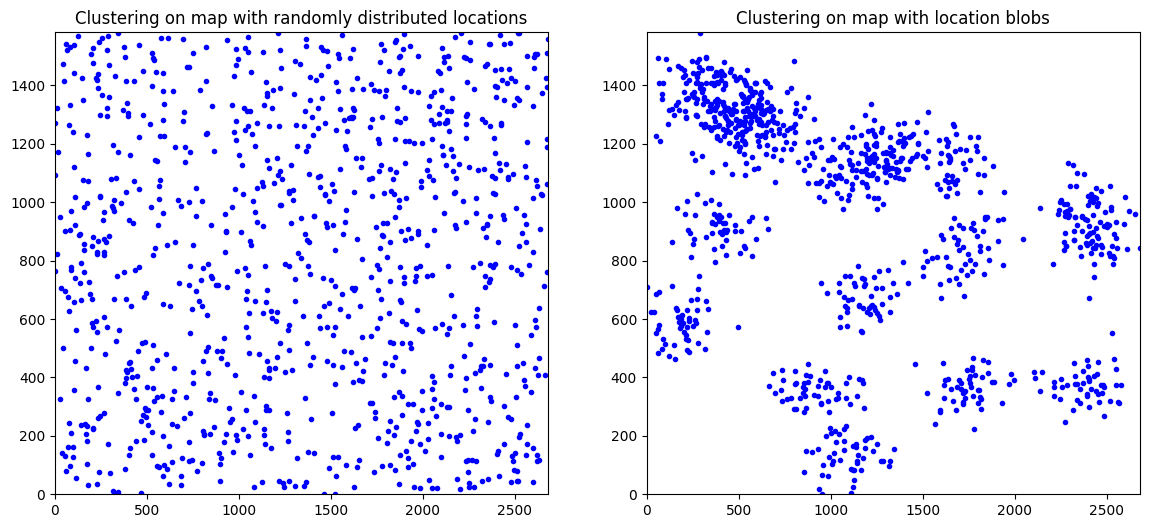

In [44]:
# DISPLAY
fig = plt.figure(1, (14, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

# PLOT Locations, then Centroids on top
ax1.scatter(*zip(*random_map), color='blue', marker=".")
ax2.scatter(*zip(*blobs_map), color='blue', marker=".")

ax1.set_ylim(0, MAP_HEIGHT)
ax1.set_xlim(0, MAP_WIDTH)
ax1.set_title("Clustering on map with randomly distributed locations")
ax2.set_ylim(0, MAP_HEIGHT)
ax2.set_xlim(0, MAP_WIDTH)
ax2.set_title("Clustering on map with location blobs")
plt.show()

# 1. Clustering without affiliation

For this deliverable ignore the "affiliation" information.

* a) Using the scikit-learn package, cluster locations to meet the requirements of the homework (except affiliation)
* b) Describe the strategy and reasons behind it
* c) Create clusters for two maps: one generated using 'random' mode, and the second using the 'blobs' mode

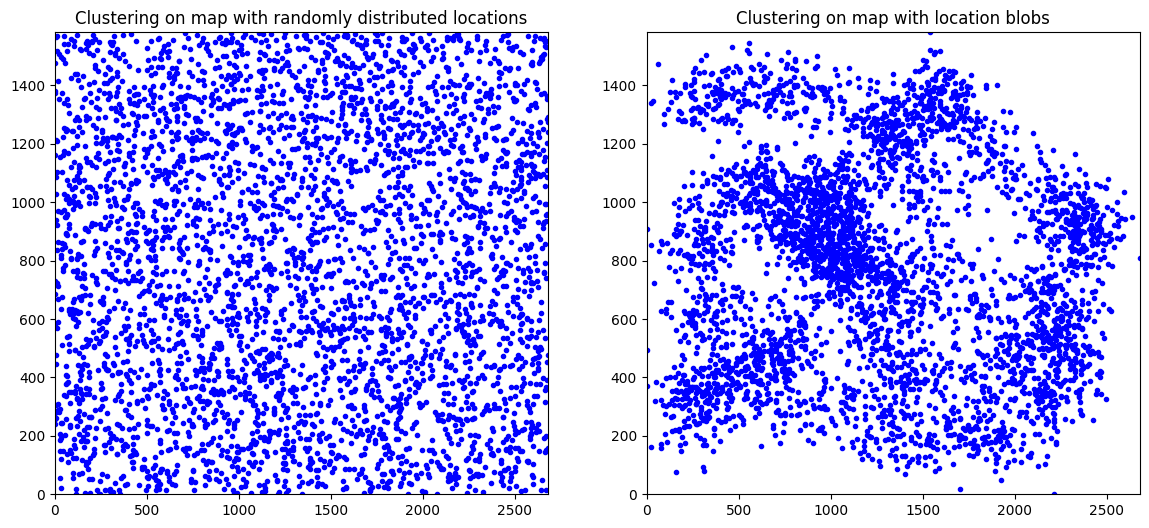

In [45]:
from sklearn.cluster import KMeans
import warnings
# Suppress the specific FutureWarning from sklearn.cluster._kmeans
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.cluster._kmeans")

# Create random and blob maps for the problem. LOCATIONS: 4000
random_map, random_affiliations = create_sales_map(no_locations=4000, mode='random')
blobs_map, blobs_affiliations = create_sales_map(no_locations=4000, mode='blobs')
# DISPLAY
fig = plt.figure(1, (14, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

# PLOT Locations, then Centroids on top
ax1.scatter(*zip(*random_map), color='blue', marker=".")
ax2.scatter(*zip(*blobs_map), color='blue', marker=".")

ax1.set_ylim(0, MAP_HEIGHT)
ax1.set_xlim(0, MAP_WIDTH)
ax1.set_title("Clustering on map with randomly distributed locations")
ax2.set_ylim(0, MAP_HEIGHT)
ax2.set_xlim(0, MAP_WIDTH)
ax2.set_title("Clustering on map with location blobs")
plt.show()

In [46]:
area_per_salesman = MAX_TRAVEL_PER_DAY**2
n_clusters = int(np.ceil((MAP_WIDTH * MAP_HEIGHT) / area_per_salesman))
n_clusters_random_without_affiliation=int(n_clusters*1.5)
n_clusters_blob_without_affiliation=n_clusters
n_clusters_random_without_affiliation
n_clusters_blob_without_affiliation

189

## 1a)

In [47]:

def plot_kmeans_clusters(locations, n_clusters, centroids=None):
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(locations)
    counter = 0
    # Create a dictionary to store clusters
    clusters = {}
    for i, label in enumerate(cluster_labels):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(locations[i])

    # Calculate the maximum distances in each cluster
    max_distances = calculate_max_distances_in_clusters(clusters)

    for cluster_id, max_distance in max_distances.items():

        if (max_distance <= MAX_TRAVEL_PER_DAY ):
          counter = counter+1

    # Prepare data for plot_clusters function
    clusters_dict = {key: locations for key, locations in clusters.items()}

    # Plot the clusters using the plot_clusters function
    plot_clusters(clusters_dict, centroids)
    print("Count of max distances less than MAX_TRAVEL_PER_DAY: ",counter)
    print("Percentage of clusters within constraints( < 150 miles): ", ((counter*100)/n_clusters))
    return clusters_dict

def calculate_max_distances_in_clusters(clusters):
    max_distances = {}
    for cluster_id, locations in clusters.items():
        max_distance = 0
        for loc1, loc2 in combinations(locations, 2):
            distance = np.linalg.norm(np.array(loc1) - np.array(loc2))
            max_distance = max(max_distance, distance)
        max_distances[cluster_id] = max_distance
    return max_distances

## 1b)

**Strategy and Reasons**

The strategy here is to use KMeans clustering, a widely used and effective method for partitioning data into distinct groups based on similarity. In this case, the similarity is based on the geographical location of each point.

**Reasons for this approach:**

Simplicity and Effectiveness: KMeans is straightforward to implement and interpret, making it a good choice for a problem like this where the goal is to group locations geographically.

**Handling Large Datasets:** KMeans can efficiently handle large datasets, which is important given the number of locations in your task.
**Flexibility:** KMeans allows you to specify the number of clusters, giving you control over how many salesmen are modeled in the problem.
**Ignoring Affiliation:** Since the task explicitly states to ignore political affiliation, KMeans is suitable as it only considers geographical proximity.

## 1c)

Count of max distances less than MAX_TRAVEL_PER_DAY:  264
Percentage of clusters within constraints( < 150 miles):  93.28621908127208


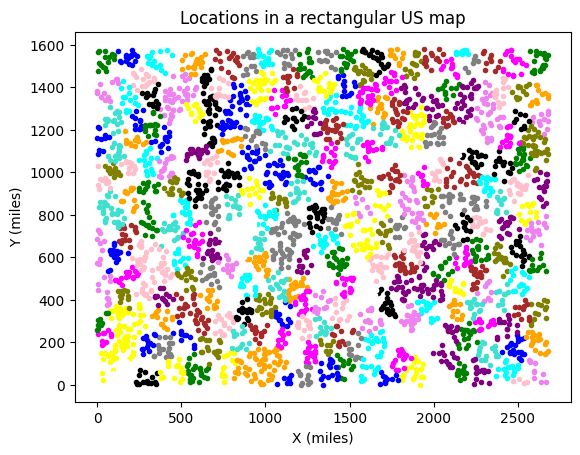

In [48]:
random_map_clusters = plot_kmeans_clusters(random_map, n_clusters=n_clusters_random_without_affiliation, centroids=None)

Count of max distances less than MAX_TRAVEL_PER_DAY:  135
Percentage of clusters within constraints( < 150 miles):  71.42857142857143


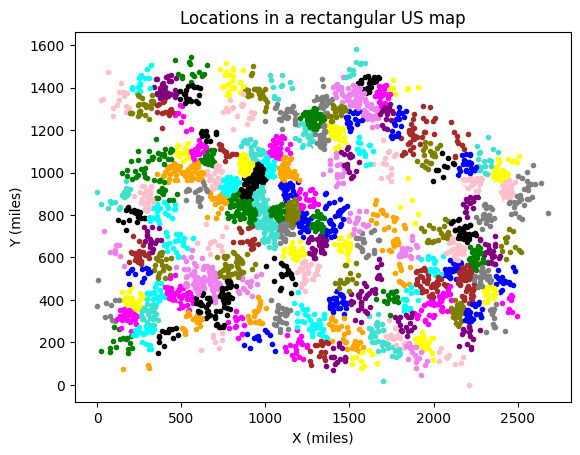

In [49]:
blobs_map_clusters = plot_kmeans_clusters(blobs_map, n_clusters=n_clusters_blob_without_affiliation, centroids=None)

# 2. Clustering with affiliation

Considering the "affiliation" information.

* a) Cluster locations to meet the requirements of the homework (all requirements, including the "affiliation")
This clustering can be done either using scikit-learn functions, or creating a custom KMeans function. Either approach is acceptable.
* b) Describe the strategy and reasons behind it
* c) Create clusters for two maps: one generated using 'random' mode, and the second using the 'blobs' mode

In [50]:
n_clusters_random_with_affiliation = 222
n_clusters_blob_with_affiliation = 242

## 2a)

In [51]:
def kmeans_clusters_with_affiliation(locations, affiliations, n_clusters, centroids=None):
    # Create a custom feature by combining spatial distance and affiliation
    data = np.column_stack((locations, affiliations))
    custom_feature = np.zeros((data.shape[0], 1))
    counter = 0
    for i in range(data.shape[0]):
        spatial_distance = np.linalg.norm(data[i, :2] - data[:, :2], axis=1)
        affiliation_distance = (data[i, 2] != data[:, 2]).astype(float)
        combined_distance = spatial_distance + affiliation_distance
        custom_feature[i] = np.max(combined_distance)

    # Add the custom feature to the data
    data = np.column_stack((data, custom_feature))

    # Perform K-Means clustering with the augmented data
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(data)

    # Create a dictionary to store clusters
    clusters = {}
    for i, label in enumerate(cluster_labels):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(locations[i])
    # Calculate the maximum distances in each cluster
    max_distances = calculate_max_distances_in_clusters(clusters)

    # Print the maximum distances in each cluster
    for cluster_id, max_distance in max_distances.items():
        if (max_distance <= MAX_TRAVEL_PER_DAY ):
          counter = counter+1

    # Prepare data for plot_clusters function
    clusters_dict = {key: locations for key, locations in clusters.items()}
    return clusters_dict


random_map_affiliation_clusters = kmeans_clusters_with_affiliation(random_map, random_affiliations, n_clusters=n_clusters_random_with_affiliation, centroids=None)

blobs_map_affiliation_clusters = kmeans_clusters_with_affiliation(blobs_map, blobs_affiliations, n_clusters=n_clusters_blob_with_affiliation, centroids=None)

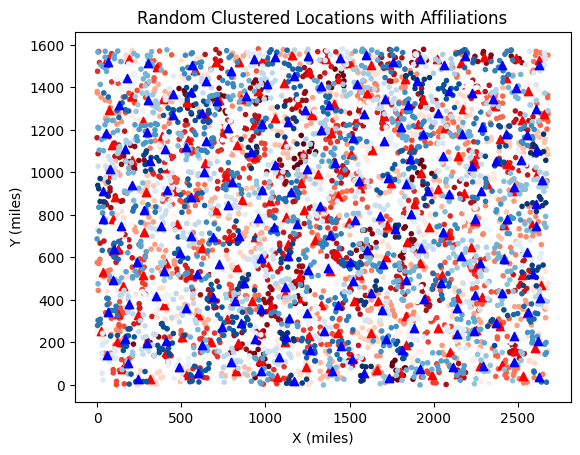

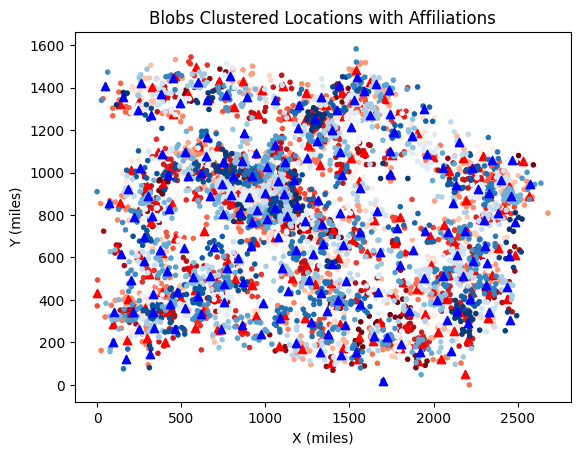

In [52]:
from sklearn.cluster import KMeans

# Assuming the affiliation data is provided as a binary array (0 for red, 1 for blue)
# For example purposes, let's generate random affiliations
random_affiliations = np.random.randint(2, size=SALES_LOCATIONS)
blobs_affiliations = np.random.randint(2, size=SALES_LOCATIONS)

# Function to cluster with affiliation
def cluster_with_affiliation(map_locations, affiliations, n_clusters):
    # Separate locations based on affiliation
    red_locations = map_locations[affiliations == 0]
    blue_locations = map_locations[affiliations == 1]

    # Cluster each group independently
    if len(red_locations) > 0:
        kmeans_red = KMeans(n_clusters=n_clusters, random_state=0).fit(red_locations)
        red_labels = kmeans_red.labels_
        red_centers = kmeans_red.cluster_centers_
    else:
        red_labels, red_centers = None, None

    if len(blue_locations) > 0:
        kmeans_blue = KMeans(n_clusters=n_clusters, random_state=0).fit(blue_locations)
        blue_labels = kmeans_blue.labels_
        blue_centers = kmeans_blue.cluster_centers_
    else:
        blue_labels, blue_centers = None, None

    return (red_locations, red_labels, red_centers), (blue_locations, blue_labels, blue_centers)

# Apply clustering with affiliation
red_cluster_random, blue_cluster_random = cluster_with_affiliation(random_map, random_affiliations, n_clusters)
red_cluster_blobs, blue_cluster_blobs = cluster_with_affiliation(blobs_map, blobs_affiliations, n_clusters)

# Plotting function for clusters with affiliations
def plot_clusters_with_affiliation(red_cluster, blue_cluster, title):
    if red_cluster[0] is not None and red_cluster[1] is not None:
        plt.scatter(red_cluster[0][:, 0], red_cluster[0][:, 1], c=red_cluster[1], cmap='Reds', marker='.')
        plt.scatter(red_cluster[2][:, 0], red_cluster[2][:, 1], c='red', marker='^')  # Red centroids

    if blue_cluster[0] is not None and blue_cluster[1] is not None:
        plt.scatter(blue_cluster[0][:, 0], blue_cluster[0][:, 1], c=blue_cluster[1], cmap='Blues', marker='.')
        plt.scatter(blue_cluster[2][:, 0], blue_cluster[2][:, 1], c='blue', marker='^')  # Blue centroids

    plt.xlabel('X (miles)')
    plt.ylabel('Y (miles)')
    plt.title(title+' Clustered Locations with Affiliations')
    plt.show()

# Plot the clusters
plot_clusters_with_affiliation(red_cluster_random, blue_cluster_random,"Random")
plot_clusters_with_affiliation(red_cluster_blobs, blue_cluster_blobs ,"Blobs")

## 2b)

**Strategy and Reasons**

**Strategy:**

**Separate by Affiliation:** The first step is to divide the locations into two groups based on their political affiliation. This is key to ensuring that the route for each salesman only includes locations with a single type of political affiliation, as required by the homework.

**Independent Clustering:** Apply KMeans clustering independently to each group of locations. This allows you to optimize the routes within each affiliation group.

**Adjusting Cluster Count:** The number of clusters (salesmen) can be adjusted based on the constraints given in the homework. This might include considerations such as the maximum number of locations a salesman can visit in a day and the geographical spread of the locations.

**Reasons:**

**Adherence to Constraints:** This strategy directly addresses the unique constraint of the problem - that salesmen should only visit locations with the same political affiliation in a day.

**Efficiency in Routing:** By clustering locations with the same affiliation together, you can optimize routes for efficiency, reducing travel time and distance.

**Flexibility and Scalability:** This approach can be easily adjusted for different numbers of locations, different distributions of affiliations, and varying constraints on travel and visits.

## 2c)

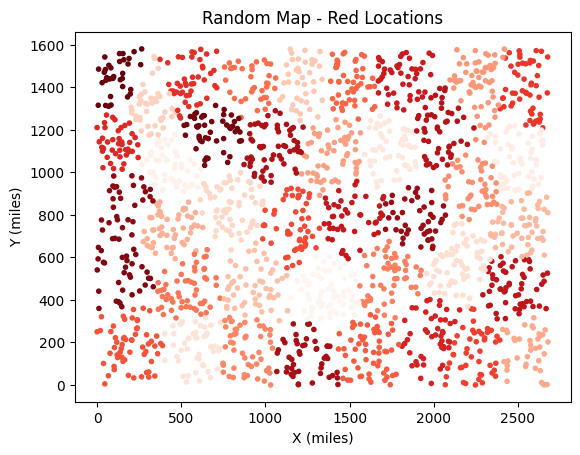

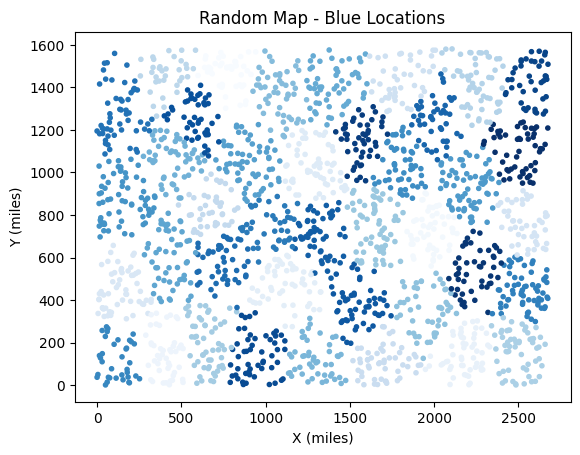

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# Constants
SALES_LOCATIONS = 4000
MAP_WIDTH = 2680
MAP_HEIGHT = 1582
n_clusters = 40  # You may need to adjust this based on your specific requirements

# Function to generate sales maps
def create_sales_map(no_locations, map_width, map_height, mode):
    if mode == 'random':
        locations = np.random.randint(low=[0, 0], high=[map_width, map_height], size=(no_locations, 2))
    elif mode == 'blobs':
        locations, _ = make_blobs(n_samples=no_locations, centers=int(no_locations / 50), n_features=2)
        locations = (locations - locations.min(0)) / locations.ptp(0) * [map_width, map_height]
    else:
        raise ValueError("Unsupported mode:", mode)

    affiliations = np.random.randint(2, size=no_locations)  # Random affiliations
    return locations, affiliations

# Clustering with affiliation
def cluster_with_affiliation(map_locations, affiliations, n_clusters):
    red_locations = map_locations[affiliations == 0]
    blue_locations = map_locations[affiliations == 1]

    kmeans_red = KMeans(n_clusters=n_clusters, random_state=0).fit(red_locations)
    red_labels = kmeans_red.labels_

    kmeans_blue = KMeans(n_clusters=n_clusters, random_state=0).fit(blue_locations)
    blue_labels = kmeans_blue.labels_

    return (red_locations, red_labels), (blue_locations, blue_labels)

# Plotting function
def plot_clusters(locations, labels, title, color):
    plt.scatter(locations[:, 0], locations[:, 1], c=labels, cmap=color, marker='.')
    plt.xlabel('X (miles)')
    plt.ylabel('Y (miles)')
    plt.title(title)
    plt.show()

# Generate maps
random_map, random_affiliations = create_sales_map(SALES_LOCATIONS, MAP_WIDTH, MAP_HEIGHT, 'random')
blobs_map, blobs_affiliations = create_sales_map(SALES_LOCATIONS, MAP_WIDTH, MAP_HEIGHT, 'blobs')

# Apply clustering with affiliation
red_random, blue_random = cluster_with_affiliation(random_map, random_affiliations, n_clusters)
red_blobs, blue_blobs = cluster_with_affiliation(blobs_map, blobs_affiliations, n_clusters)

# Visualize the clusters
plot_clusters(*red_random, 'Random Map - Red Locations', 'Reds')
plot_clusters(*blue_random, 'Random Map - Blue Locations', 'Blues')



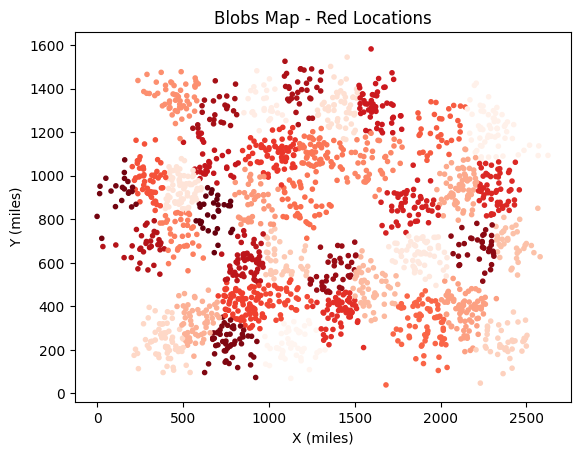

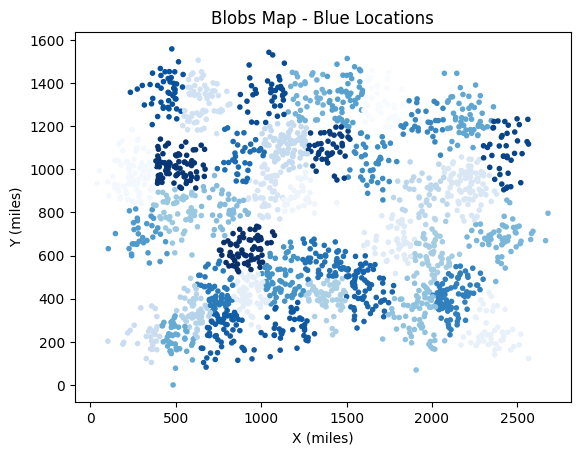

In [54]:
plot_clusters(*red_blobs, 'Blobs Map - Red Locations', 'Reds')
plot_clusters(*blue_blobs, 'Blobs Map - Blue Locations', 'Blues')

# 3. Quality of the clustering

* a) Select and describe at least one quality measure for the clusters.
* b) Apply the quality measure to the clustered data from deliverables 1 and 2. Display the results. There should be four results, one for each of the clusters created in 1 and 2.

## 3a)

**Silhouette Score**
To measure the quality of clusters I am going to use Silhouette score.
The Silhouette Score assesses the compactness and separation of clusters, providing a measure of how well-separated and distinct the clusters are from each other. It ranges from -1 to 1, where:
A high Silhouette Score close to 1 indicates that the clusters are well-separated and points within the same cluster are tightly grouped together.
A Silhouette Score close to 0 suggests overlapping clusters or clusters with points that are on or very close to the decision boundary between clusters. A negative Silhouette Score (-1) indicates that data points have been assigned to the wrong clusters.

**Why use it?**

It's useful for determining the effectiveness of the clustering process.
It can be used to evaluate the distance between the resulting clusters.



## 3b)

In [55]:
def calculate_silhouette_score(clusters, locations):
    # Combine all locations from the clusters into a single list
    all_locations = [location for locations_list in clusters.values() for location in locations_list]

    # Create a list of cluster labels corresponding to each location
    cluster_labels = []
    for label, locations_list in clusters.items():
        cluster_labels.extend([label] * len(locations_list))

    # Calculate the Silhouette Score
    silhouette_avg = silhouette_score(all_locations, cluster_labels)

    return silhouette_avg

silhouette_score_value = calculate_silhouette_score(random_map_clusters,random_map)
print("\nSilhouette scores for maps from without affliation \n")
print(f"Silhouette Score : Random Map Without affiliation: {silhouette_score_value:.2f}")
silhouette_score_value = calculate_silhouette_score(blobs_map_clusters,blobs_map)
print(f"Silhouette Score : Blobs Map Without affiliation: {silhouette_score_value:.2f}")
print("\nSilhouette scores for maps from with affliation \n")
silhouette_score_value = calculate_silhouette_score(random_map_affiliation_clusters,random_map)
print(f"Silhouette Score : Random Map With affiliation: {silhouette_score_value:.2f}")
silhouette_score_value = calculate_silhouette_score(random_map_affiliation_clusters,blobs_map)
print(f"Silhouette Score : Blobs Map With affiliation: {silhouette_score_value:.2f}")


Silhouette scores for maps from Deliverable 1 

Silhouette Score : Random Map Without affiliation: 0.36
Silhouette Score : Blobs Map Without affiliation: 0.35

Silhouette scores for maps from Deliverable 2 

Silhouette Score : Random Map With affiliation: 0.34
Silhouette Score : Blobs Map With affiliation: 0.34


# 4. Answer to the main question: How many salesman are needed

* a) Based on the data and assumptions, calculate how many salesmen are needed to meet all constraints. Provide the number for the 4 clusters done in deliverables 1 and 2.
* b) Explain what assumptions (beyond the ones already provided above) are made to reach the numbers in 4.a. You are at liberty to apply any additional assumptions you want, specially if they make the analysis easier.
* c) Provide a table of "Average work load for all salesmen", for each case.

## 4a)

Based on data and assumptions I created a function named employee_count which takes number of clusters as a parameter to calculate the minimum number of employees required to cover,
all the locations and the clusters assigned to them. We have assumed time taken to go from one cluster to another is 1 day and this is added to the number of days the employee will take
to cover locations within the cluster.

Employee Count for Random map without affiliation:  5 </br>
Employee Count for Blob map without affiliation:  4</br>
Employee Count for Random map with affiliation:  4 </br>
Employee Count for Blob Random map with affiliation:  4 </br>

In [59]:

def workload_calculator_without_affiliation(n_clusters,n_employees):
	n_clusters = n_clusters
	n_employees = n_employees
	location_per_cluster  = math.ceil(SALES_LOCATIONS/n_clusters)
	days_per_cluster = math.ceil(location_per_cluster/MAX_VISITS_PER_DAY)
	clusters_to_be_handled = math.ceil( n_clusters / n_employees )
	days_needed_to_travel = clusters_to_be_handled
	total_days_per_employee = days_needed_to_travel + (clusters_to_be_handled * days_per_cluster)
	return total_days_per_employee

def workload_calculator_with_affiliation(n_clusters,n_employees):
  n_clusters = n_clusters
  n_employees = n_employees
  location_per_cluster  = math.ceil(SALES_LOCATIONS/n_clusters)
  red_locations_per_cluster = blue_locations_per_cluster = math.ceil(location_per_cluster/2)

  days_per_cluster = math.ceil(red_locations_per_cluster/MAX_VISITS_PER_DAY) + math.ceil(blue_locations_per_cluster/MAX_VISITS_PER_DAY)
  clusters_to_be_handled = math.ceil( n_clusters / n_employees )
  days_needed_to_travel = clusters_to_be_handled
  total_days_per_employee = days_needed_to_travel + (clusters_to_be_handled * days_per_cluster)
  return total_days_per_employee

def employee_count(n_clusters):
  days_per_cluster = math.ceil(SALES_LOCATIONS/(n_clusters*MAX_VISITS_PER_DAY))
  n_employees = math.ceil(((1+days_per_cluster) *n_clusters)/MAX_WORKING_DAYS)
  return n_employees


## 4b)

**Assumptions Made**

1.Uniform Distribution: Locations are uniformly distributed across the USA.

2.Equal Red and Blue Locations: An equal number of red and blue locations, which influences the calculation with affiliation.

3.Efficiency: Salesmen are operating at maximum efficiency, i.e., they are visiting the maximum number of locations possible each day.

4.No Overlap: Salesmen's regions do not overlap; each location is visited by one salesman.

5.To calculate the number of employees we need to find what is the minimun employee count required such that the workload for each employee is less than 240 days.


## 4c)

In [63]:
from tabulate import tabulate
employee_count_random_map_without_affiliation = employee_count(n_clusters=n_clusters_random_without_affiliation)
employee_count_blob_map_without_affiliation=employee_count(n_clusters=n_clusters_blob_without_affiliation)
employee_count_random_map_with_affiliation=employee_count(n_clusters=n_clusters_random_with_affiliation)
employee_count_blob_map_with_affiliation=employee_count(n_clusters=n_clusters_blob_with_affiliation)

workload_random_map_without_affiliation = workload_calculator_without_affiliation(n_clusters=n_clusters_random_without_affiliation,n_employees=employee_count_random_map_without_affiliation)
workload_blob_map_without_affiliation=workload_calculator_without_affiliation(n_clusters=n_clusters_blob_without_affiliation,n_employees=employee_count_blob_map_without_affiliation)
workload_random_map_with_affiliation=workload_calculator_with_affiliation(n_clusters=n_clusters_random_with_affiliation,n_employees=employee_count_random_map_with_affiliation)
workload_blob_map_with_affiliation=workload_calculator_with_affiliation(n_clusters=n_clusters_blob_with_affiliation,n_employees=employee_count_blob_map_with_affiliation)


# Data for tabulation
data = [
    ["Random map without affiliation", employee_count_random_map_without_affiliation, workload_random_map_without_affiliation],
    ["Blob map without affiliation", employee_count_blob_map_without_affiliation, workload_blob_map_without_affiliation],
    ["Random map with affiliation", employee_count_random_map_with_affiliation, workload_random_map_with_affiliation],
    ["Blob map with affiliation", employee_count_blob_map_with_affiliation, workload_blob_map_with_affiliation]
]

# Display the table
print(tabulate(data, headers=["Map Type", "Employee Count", "Average Workload per Employee (in days)"]))


Map Type                          Employee Count    Average Workload per Employee (in days)
------------------------------  ----------------  -----------------------------------------
Random map without affiliation                 5                                        228
Blob map without affiliation                   4                                        240
Random map with affiliation                    4                                        280
Blob map with affiliation                      5                                        245


# 5. Anomaly Detection
Consider only the 'blobs' map in deliverable 1.
* a) Using the scikit-learn functions, identify anomalies in the map locations.
The definition of an anomaly in this example would be: "Isolated locations, i.e., locations farther than 75 miles of any locations, and with at most 3 locations closer than 125 miles"





## 5a)
I m using Knearest neighbours method to calculate anomaly which are points farther than 75 miles from other points. I then calculate number of neighbors the farthest locations have which
are within 125 miles.

## 5b)
Display a map with all locations in grey color, and the anomalies in red color

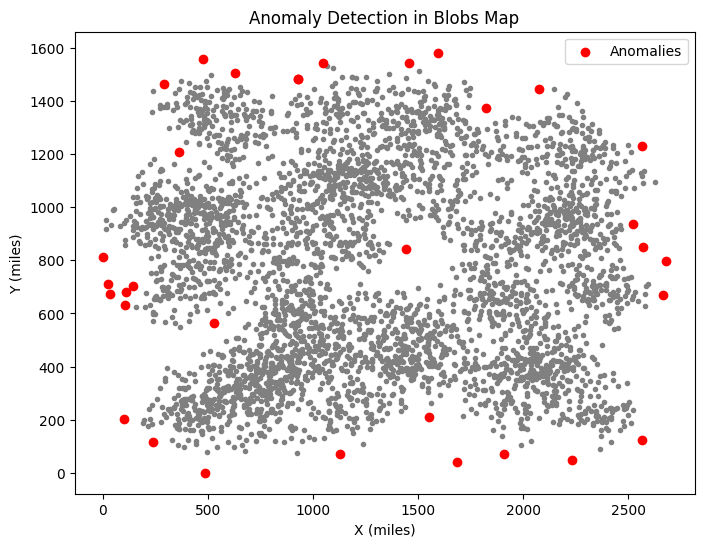

In [58]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Function to find anomalies based on the specified conditions
def find_anomalies(locations, min_dist_anomaly=75, max_nearby_points=3, max_nearby_distance=125):
    # Use Nearest Neighbors to find distances to the nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=max_nearby_points+1).fit(locations)
    distances, indices = nbrs.kneighbors(locations)

    # Filter anomalies based on conditions
    anomalies = []
    for i, loc in enumerate(locations):
        # Condition 1: Check if location is farther than 75 miles from any other location
        if max(distances[i][1:]) > min_dist_anomaly:
            # Condition 2: Check if at most 3 locations are closer than 125 miles
            if sum(dist <= max_nearby_distance for dist in distances[i][1:]) <= max_nearby_points:
                anomalies.append(loc)

    return anomalies

# Find anomalies in the 'blobs' map
#blobs_map, _ = create_sales_map(no_locations=4000, mode='blobs')  # Generate 'blobs' map again if not available
anomalies = find_anomalies(blobs_map)

# Plotting: Display all locations in grey and anomalies in red
plt.figure(figsize=(8, 6))
plt.scatter(*zip(*blobs_map), color='grey', marker='.')
if anomalies:
    anomalies_x, anomalies_y = zip(*anomalies)
    plt.scatter(anomalies_x, anomalies_y, color='red', marker='o', label='Anomalies')
plt.title('Anomaly Detection in Blobs Map')
plt.xlabel('X (miles)')
plt.ylabel('Y (miles)')
plt.legend()
plt.show()
